In [ ]:
# import necessary libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Select Yahoo Finance ticker symbol
ticker = "BTC-USD"

# ticker= "^SPX"
#ticker = "FTSEMIB.MI"
#ticker = "DAX"
#ticker = "^FCHI"
#ticker ="^IBEX"
#ticker = "^RUT"
#ticker = "^DJI"
#ticker = "^NDX"

#ticker = "IWDA.AS"
#ticker = "CSSPX.MI"
#ticker = "XLV"

In [24]:
# download historical data from Yahoo Finance
df = yf.download(ticker, start='1950-01-01', end=None)

C:\Users\calli\AppData\Local\Temp\ipykernel_30560\4060644827.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='1950-01-01', end=None)
[*********************100%***********************]  1 of 1 completed


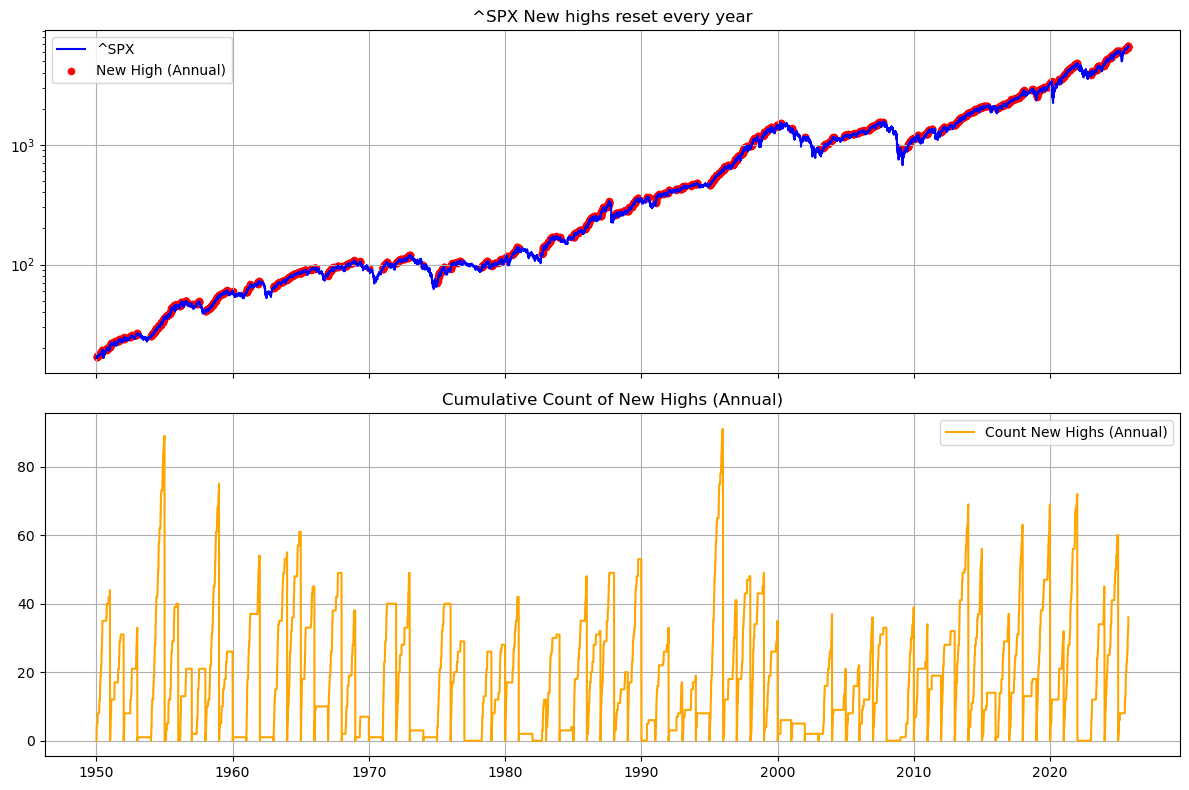

In [25]:
# Flatten the columns if they are a MultiIndex
df.columns = [
    f"{col[0]}_{col[1]}" if col[1] else col[0]
    for col in df.columns
]
# ('Close', '^GSPC') will become 'Close_^GSPC'.
# If the second level of the MultiIndex is empty, it will return only col[0].

# Systematic Data Cleaning
df.sort_index(inplace=True)
df.dropna(inplace=True)

# Select the correct 'Close' column
close_col = [col for col in df.columns if col.startswith("Close")][0]

# Add a 'year' column for grouping
df['year'] = df.index.year

# Calculate the rolling maximum of the 'Close' price within each year
df['rolling_max_year'] = df.groupby('year')[close_col].cummax()

# Shift the rolling maximum by one day to compare today's close with yesterday's rolling max
df['rolling_max_shifted_year'] = df.groupby('year')['rolling_max_year'].shift(1)

# 8. If today's close > yesterday's rolling max (within the same year) => new high
df['is_new_high_year'] = df[close_col] > df['rolling_max_shifted_year']

# 9. Count cumulatively the new highs, *resetting* at the beginning of each year
df['new_high_count_year'] = df.groupby('year')['is_new_high_year'].cumsum()

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# First Chart S&P 500, log scale with red dots for new annual highs
axs[0].set_title(f"{ticker} New highs reset every year")
axs[0].semilogy(df[close_col], label=ticker, color='blue')
axs[0].scatter(
    df.index[df['is_new_high_year']],
    df.loc[df['is_new_high_year'], close_col],
    color='red',
    marker='o',
    s=20,
    label='New High (Annual)'
)
axs[0].legend(loc='best')
axs[0].grid(True)

# Second Chart: Cumulative count of new highs, reset every January 1st
axs[1].set_title("Cumulative Count of New Highs (Annual)")
axs[1].plot(
    df['new_high_count_year'],
    color='orange',
    label='Count New Highs (Annual)'
)
axs[1].legend(loc='best')
axs[1].grid(True)

plt.tight_layout()
plt.show()

    year  number_of_new_highs  first_close   last_close  yearly_return_pct
0   1950                   44    16.660000    20.430000          22.629055
1   1951                   31    20.770000    23.770000          14.443909
2   1952                   33    23.799999    26.570000          11.638658
3   1953                    1    26.540001    24.809999          -6.518468
4   1954                   89    24.950001    35.980000          44.208411
..   ...                  ...          ...          ...                ...
71  2021                   72  3700.649902  4766.180176          28.793058
72  2022                    0  4796.560059  3839.500000         -19.953051
73  2023                   45  3824.139893  4769.830078          24.729487
74  2024                   60  4742.830078  5881.629883          24.010976
75  2025                   36  5868.549805  6715.790039          14.436961

[76 rows x 5 columns]

Descriptive Statistics:
              year  number_of_new_highs  first_close

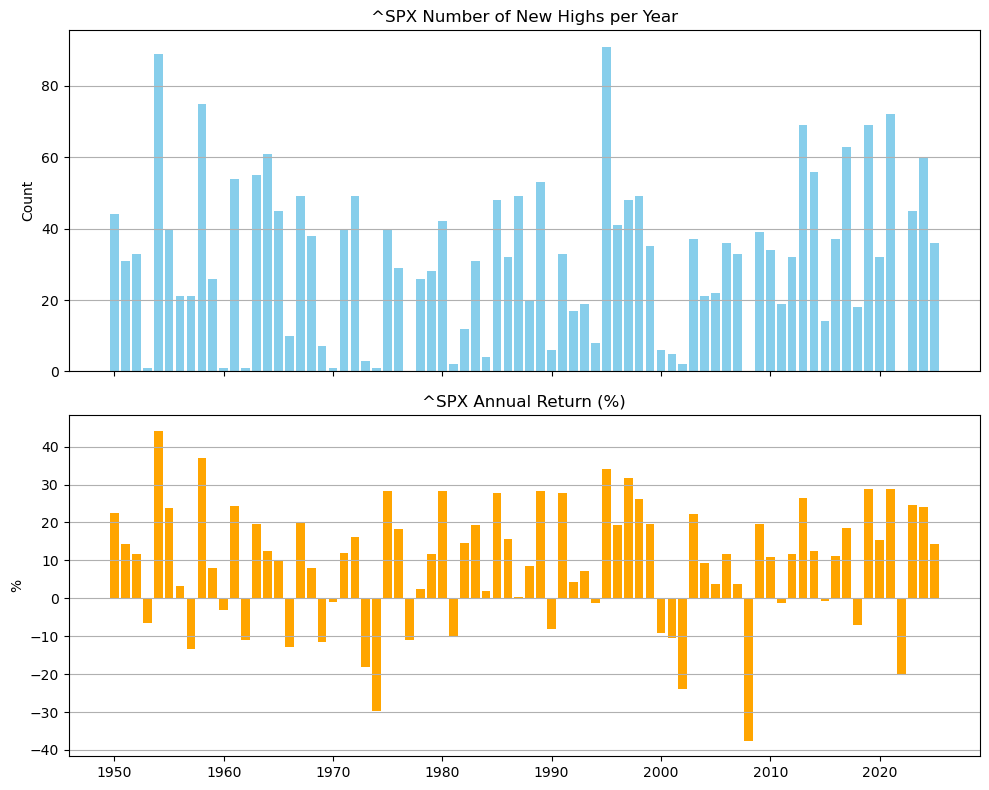

In [26]:
# Select the correct 'Close' column (if needed)
close_col = [col for col in df.columns if col.startswith("Close")][0]

# Group by year to calculate:
yearly_data = (
    df
    .groupby('year')
    .agg(
        number_of_new_highs=('is_new_high_year', 'sum'),  # sum of True values = is_new_high_year
        first_close=(close_col, 'first'),                 # first closing price of the year
        last_close=(close_col, 'last')                    # last closing price of the year
    )
)

# Calculating yearly return in percentage
yearly_data['yearly_return_pct'] = 100.0 * (yearly_data['last_close'] / yearly_data['first_close'] - 1)

# Reset index to show 'year' as a column, for easier printing
yearly_data.reset_index(inplace=True)

# Show the result in a tabular format
print(yearly_data)

# Print some descriptive statistics
print("\nDescriptive Statistics:")
print(yearly_data.describe())

# Plot the results (number of new highs and annual return) in two bar charts
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Number of new highs
axes[0].bar(yearly_data['year'], yearly_data['number_of_new_highs'], color='skyblue')
axes[0].set_title(f"{ticker} Number of New Highs per Year")
axes[0].set_ylabel("Count")
axes[0].grid(axis='y')

# Annual return in %
axes[1].bar(yearly_data['year'], yearly_data['yearly_return_pct'], color='orange')
axes[1].set_title(f"{ticker} Annual Return (%)")
axes[1].set_ylabel("%")
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

===== NEW HIGHS ANALYSIS VS POSITIVE YEARS =====
Total years analyzed: 76

-- Positive Years --
   Min new highs: 4
   Max new highs: 91
   Mean new highs: 41.6

-- Negative Years --
   Min new highs: 0
   Max new highs: 21
   Mean new highs: 6.0

-- Probability of Positive Year Given New Highs Threshold --
   #NewHighs >=  0:  n=76 years,  72.4% positive
   #NewHighs >=  5:  n=64 years,  84.4% positive
   #NewHighs >= 10:  n=59 years,  91.5% positive
   #NewHighs >= 20:  n=52 years,  98.1% positive
   #NewHighs >= 30:  n=43 years,  100.0% positive
   #NewHighs >= 40:  n=27 years,  100.0% positive
   #NewHighs >= 50:  n=13 years,  100.0% positive
   #NewHighs >= 60:  n=9 years,  100.0% positive
   #NewHighs >= 70:  n=4 years,  100.0% positive


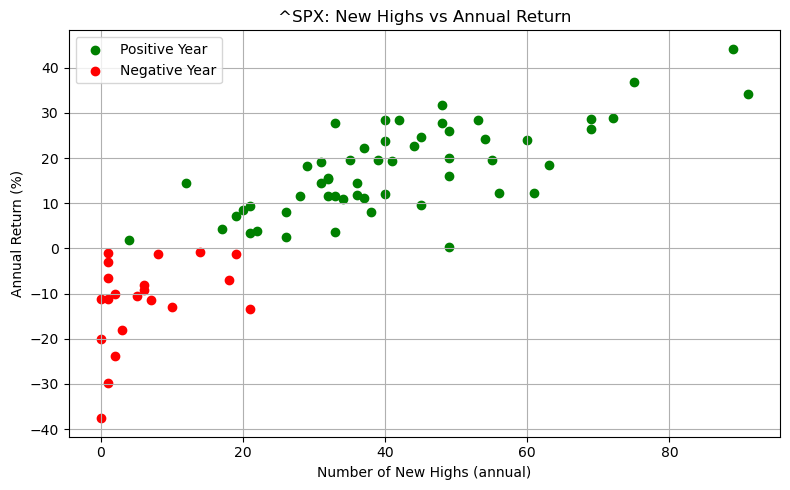

In [27]:
# True column if the year was positive
yearly_data['is_positive_year'] = yearly_data['yearly_return_pct'] > 0

# Split into positive and negative years for descriptive statistics
pos_years = yearly_data[yearly_data['is_positive_year']]
neg_years = yearly_data[~yearly_data['is_positive_year']]

# Print some basic info
print("===== NEW HIGHS ANALYSIS VS POSITIVE YEARS =====")
print(f"Total years analyzed: {len(yearly_data)}")

print("\n-- Positive Years --")
print(f"   Min new highs: {pos_years['number_of_new_highs'].min()}")
print(f"   Max new highs: {pos_years['number_of_new_highs'].max()}")
print(f"   Mean new highs: {pos_years['number_of_new_highs'].mean():.1f}")

print("\n-- Negative Years --")
print(f"   Min new highs: {neg_years['number_of_new_highs'].min()}")
print(f"   Max new highs: {neg_years['number_of_new_highs'].max()}")
print(f"   Mean new highs: {neg_years['number_of_new_highs'].mean():.1f}")

# Show the probability of a positive year given a certain threshold of new highs
print("\n-- Probability of Positive Year Given New Highs Threshold --")
thresholds = [0, 5, 10, 20, 30, 40, 50, 60, 70]  # example thresholds

for t in thresholds:
    subset = yearly_data[yearly_data['number_of_new_highs'] >= t]
    if len(subset) > 0:
        prob_pos = 100.0 * subset['is_positive_year'].mean()
        print(f"   #NewHighs >= {t:2d}:  n={len(subset)} years,  {prob_pos:.1f}% positive")
    else:
        print(f"   #NewHighs >= {t:2d}:  no historical year with >= {t} new highs")

# Scatter Plot: # new highs (X) vs. annual return (Y)
plt.figure(figsize=(8, 5))
plt.title(f"{ticker}: New Highs vs Annual Return")
plt.xlabel("Number of New Highs (annual)")
plt.ylabel("Annual Return (%)")

# - Positive years in green, negative years in red
plt.scatter(
    pos_years['number_of_new_highs'],
    pos_years['yearly_return_pct'],
    color='green', label='Positive Year'
)
plt.scatter(
    neg_years['number_of_new_highs'],
    neg_years['yearly_return_pct'],
    color='red', label='Negative Year'
)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

===== NEW HIGHS ANALYSIS VS NEXT YEAR =====
Total years analyzed (with next year present): 75

-- Years with Next Year Positive --
   Min new highs (current year): 0
   Max new highs (current year): 91
   Mean new highs: 30.7

-- Years with Next Year Negative --
   Min new highs (current year): 3
   Max new highs (current year): 72
   Mean new highs: 34.5

-- Probability of Positive Next Year Given New Highs Threshold --
   #NewHighs >=  0:  n=76 years,  71.1% positive next
   #NewHighs >=  5:  n=64 years,  67.2% positive next
   #NewHighs >= 10:  n=59 years,  69.5% positive next
   #NewHighs >= 20:  n=52 years,  67.3% positive next
   #NewHighs >= 30:  n=43 years,  67.4% positive next
   #NewHighs >= 40:  n=27 years,  70.4% positive next
   #NewHighs >= 50:  n=13 years,  61.5% positive next
   #NewHighs >= 60:  n=9 years,  77.8% positive next
   #NewHighs >= 70:  n=4 years,  75.0% positive next


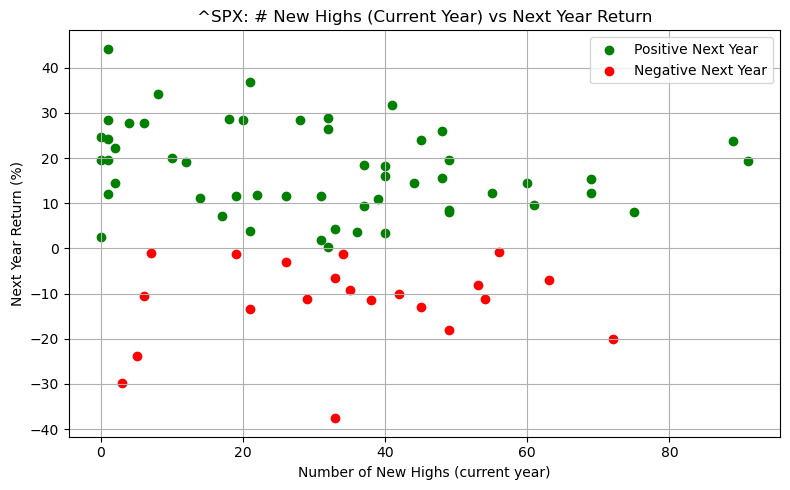

In [28]:
# Starting from 'yearly_data' DataFrame created above
yearly_data = yearly_data.sort_values('year')

# Add the column with NEXT YEAR'S RETURN
yearly_data['next_year_return_pct'] = yearly_data['yearly_return_pct'].shift(-1)

# True column if the NEXT year was positive
yearly_data['is_positive_next_year'] = yearly_data['next_year_return_pct'] > 0

# Split into "years with next year positive" and "years with next year negative"
pos_next = yearly_data[yearly_data['is_positive_next_year']]
neg_next = yearly_data[~yearly_data['is_positive_next_year']]

# Print some basic info
print("===== NEW HIGHS ANALYSIS VS NEXT YEAR =====")
print(f"Total years analyzed (with next year present): {len(yearly_data) - 1}")
# (the last year does not have a "next year" in the data, so one row is lost in shift)

print("\n-- Years with Next Year Positive --")
if len(pos_next) > 0:
    print(f"   Min new highs (current year): {pos_next['number_of_new_highs'].min()}")
    print(f"   Max new highs (current year): {pos_next['number_of_new_highs'].max()}")
    print(f"   Mean new highs: {pos_next['number_of_new_highs'].mean():.1f}")
else:
    print("   No year with next positive (strange!)")

print("\n-- Years with Next Year Negative --")
if len(neg_next) > 0:
    print(f"   Min new highs (current year): {neg_next['number_of_new_highs'].min()}")
    print(f"   Max new highs (current year): {neg_next['number_of_new_highs'].max()}")
    print(f"   Mean new highs: {neg_next['number_of_new_highs'].mean():.1f}")
else:
    print("   No year with next negative (luckily!)")

# Show the probability of a positive next year given a certain threshold of new highs in the current year
print("\n-- Probability of Positive Next Year Given New Highs Threshold --")
thresholds = [0, 5, 10, 20, 30, 40, 50, 60, 70]

for t in thresholds:
    subset = yearly_data[yearly_data['number_of_new_highs'] >= t]
    # Only years that exceed the 't' threshold of new highs
    # (Note: the last year in the dataset does not have "next_year_return_pct", so subset may exclude it)
    if len(subset) > 0:
        prob_pos = 100.0 * subset['is_positive_next_year'].mean()
        print(f"   #NewHighs >= {t:2d}:  n={len(subset)} years,  {prob_pos:.1f}% positive next")
    else:
        print(f"   #NewHighs >= {t:2d}:  no historical year with >= {t} new highs")

# Plot:
#    Asse X = Number of new highs in the current year
#    Asse Y = Annual return of the next year
plt.figure(figsize=(8, 5))
plt.title(f"{ticker}: # New Highs (Current Year) vs Next Year Return")
plt.xlabel("Number of New Highs (current year)")
plt.ylabel("Next Year Return (%)")

# - Years with positive next year in green, negative next year in red
plt.scatter(
    pos_next['number_of_new_highs'],
    pos_next['next_year_return_pct'],
    color='green', label='Positive Next Year'
)
plt.scatter(
    neg_next['number_of_new_highs'],
    neg_next['next_year_return_pct'],
    color='red', label='Negative Next Year'
)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()